# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Wednesday, November 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own group**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [30]:
# Run this cell to set up your notebook
import numpy as np
# from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning

### Question 1a

Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [31]:
bool_cases = cases.isna()
col_w_na = []
for i in cases.columns.tolist():
    num_na = bool_cases[i].sum()
    col_w_na.append(num_na)
most_col_index_cases = col_w_na.index(max(col_w_na)) # index=4, num of NaN = 10

bool_vaccinations = vaccinations.isna()
colV_w_na = []
for i in vaccinations.columns.tolist():
    num_na = bool_vaccinations[i].sum()
    colV_w_na.append(num_na)
most_col_index_vax = colV_w_na.index(max(colV_w_na)) # index = 8, num of Nan = 3020

most_null_value_col = vaccinations.columns.tolist()[most_col_index_vax]
most_null_value_col

'People_Partially_Vaccinated'

### Question 1b

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [32]:
# WARNING: not correct!!!! some datatypes are not converted, OR, do we need to fill in datatypes that are not int/float/str???
# loop through each col, if type(first cal of the col vals) == int, fill in 0, else str
# WARNING: modify the original dataframe

#cases
for i in cases.columns.tolist():
    valid_index = cases[i].first_valid_index()
    if isinstance(cases[i].values[valid_index], float):
        cases[i] = cases[i].fillna(0)
    elif isinstance(cases[i].values[valid_index], int):
        cases[i] = cases[i].fillna(0)
    elif isinstance(cases[i].values[valid_index], str):   # debug here sometimes type(str)
        cases[i] = cases[i].fillna('')
cases

        
#vaccinations
for i in vaccinations.columns.tolist():
    valid_index = vaccinations[i].first_valid_index()
    if isinstance(vaccinations[i].values[valid_index], float):       
        vaccinations[i] = vaccinations[i].fillna(0)
    elif isinstance(vaccinations[i].values[valid_index], int):
        vaccinations[i] = vaccinations[i].fillna(0)
    elif isinstance(vaccinations[i].values[valid_index], str):
        vaccinations[i] = vaccinations[i].fillna('')
vaccinations


#counties
for i in counties.columns.tolist():
    valid_index = counties[i].first_valid_index()
    if isinstance(counties[i].values[valid_index], float):
        counties[i] = counties[i].fillna(0)
    elif isinstance(counties[i].values[valid_index], int):
        counties[i] = counties[i].fillna(0)
    elif isinstance(counties[i].values[valid_index], type(str)):
        counties[i] = counties[i].fillna('')
counties


# mask_use
for i in mask_use.columns.tolist():
    valid_index = mask_use[i].first_valid_index()
    if isinstance(mask_use[i].values[valid_index], float):
        mask_use[i] = mask_use[i].fillna(0)
    elif isinstance(mask_use[i].values[valid_index], int):
        mask_use[i] = mask_use[i].fillna(0)
    elif isinstance(mask_use[i].values[valid_index], str):
        mask_use[i] = mask_use[i].fillna('')
mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268
3138,56039,0.095,0.157,0.160,0.247,0.340
3139,56041,0.098,0.278,0.154,0.207,0.264
3140,56043,0.204,0.155,0.069,0.285,0.287


### Question 1c

Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

*Hint*: Try not to use a `for` loop.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [33]:
# 后-前 = increase from the previous day, Difference with previous column

cases_date = cases.loc[:,'1/22/20':'9/12/21']
cases_date_diff = cases_date.diff(axis=1)
cases_date_row_med = cases_date_diff.median(axis = 1)  # axis = 1 means to apply the function each row. 

cases['median_increase'] = cases_date_row_med
cases

# cases['median_increase'].sum() == 29692

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,median_increase
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8959,9012,9048,9063,9108,9145,9207,9246,9287,10.0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33968,34063,34142,34246,34393,34536,34726,34872,34950,24.0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3166,3184,3197,3207,3225,3243,3260,3282,3295,3.0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,3618,3628,3641,3661,3694,3727,3752,3778,3795,3.0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,8830,8862,8899,8951,8998,9048,9095,9161,9176,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,4502,4502,4502,4568,4572,4587,4611,4611,4611,2.0
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,3053,3053,3053,3086,3141,3168,3204,3204,3204,1.0
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0.0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,1080,1080,1080,1087,1104,1111,1120,1120,1120,0.0


### Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 2
-->

In [34]:
#FIPS codes are numbers which uniquely identify geographic areas.
#State-level FIPS codes have two digits, county-level FIPS codes have five digits of which the 
#first two are the FIPS code of the state to which the county belongs.

#01        ALABAMA
#01000     Alabama
#01001     Autauga County

counties['FIPS'] = counties['STATE'].map("{:02}".format) + counties['COUNTY'].map("{:03}".format)

# county_data['POPESTIMATE2020'].sum() == 329474777

### Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 2
-->

In [35]:
#counties: FIPS. str
#cases: FIPS. float
#mask_use: COUNTYFP, int
#all inner join???

#covnert cases "FIPS" col into str
counties["FIPS"] = counties['FIPS'].astype(int)

# cases

#merge counties and cases
counties_cases_merge = pd.merge(counties, cases, how = 'inner',on = "FIPS")
counties_cases_merge

#convert mask_use 'COUNTYFP' to str, add a new col called FIPS for merge???
# mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(int)
# make_use = mask_use.rename(columns = {'COUNTYFP': 'FIPS'})


#merge mask_use and counties_cases_merge
county_data = pd.merge(counties_cases_merge, mask_use, how = 'inner', left_on = 'FIPS', right_on = 'COUNTYFP')
county_data

# # # county_data['POPESTIMATE2020'].sum()
# # #county_data.shape == (3141, 639)

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9207,9246,9287,10.0,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34726,34872,34950,24.0,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3260,3282,3295,3.0,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3752,3778,3795,3.0,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9095,9161,9176,8.0,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6111,6111,6111,3.0,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4611,4611,4611,2.0,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3204,3204,3204,1.0,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1120,1120,1120,0.0,56043,0.204,0.155,0.069,0.285,0.287


<!-- BEGIN QUESTION -->

### Question 1f

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`). Remark on any inconsistencies and propose a solution. 
<!--
BEGIN QUESTION
name: q1f
points: 2
manual: True
-->

In [36]:
#Hint: What is the population of California?
#Depending on your solution, proposing a solution can fix it as well since there is no need to modify any DataFrames.

population_gb = counties.groupby('STNAME')['POPESTIMATE2020'].sum()
population_gb.head()
# the states population seems to be twice as much as the actual population estimate (by Google)

# the actual population estimate
population = pd.DataFrame(county_data.groupby('STNAME', as_index = False).sum()[['STNAME','POPESTIMATE2020']])
population.head(), population_gb.head()

(       STNAME  POPESTIMATE2020
 0     Alabama          4921532
 1      Alaska           721812
 2     Arizona          7421401
 3    Arkansas          3030522
 4  California         39368078,
 STNAME
 Alabama        9843064
 Alaska         1462316
 Arizona       14842802
 Arkansas       6061044
 California    78736156
 Name: POPESTIMATE2020, dtype: int64)

If using groupby.sum() for the counties dataframe, the state's total population is about twice as much as the actual estimatation of the states' population. That is because in the counties dataframe, there is one row that is the sum of that state's population. If we use groupby on counties and take the sum of each state, we will get the actual population estimate times 2 because of that row containing each state's population. 
If we want to avoid doubling the state's population, we should use the county_data as our groupby dataframe because it does not contain that extra row.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Guided EDA with visualizations

<!-- BEGIN QUESTION -->

### Question 2a

Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Make sure to include the name of state in which each county is located since county names are not necessarily unique.
<!--
BEGIN QUESTION
name: q2a
points: 3
manual: True
-->

In [37]:
highest_median = county_data.sort_values("median_increase", ascending=False)[["CTYNAME","STNAME", "median_increase"]].iloc[0:50]
con = highest_median.CTYNAME + ", " + highest_median.STNAME
highest_median["COUNTY_AND_STATE"] = con
highest_median.head(5)


,CTYNAME,STNAME,median_increase,COUNTY_AND_STATE
203,Los Angeles County,California,1110.0,"Los Angeles County, California"
609,Cook County,Illinois,691.0,"Cook County, Illinois"
2622,Harris County,Texas,546.0,"Harris County, Texas"
361,Miami-Dade County,Florida,529.0,"Miami-Dade County, Florida"
102,Maricopa County,Arizona,504.0,"Maricopa County, Arizona"


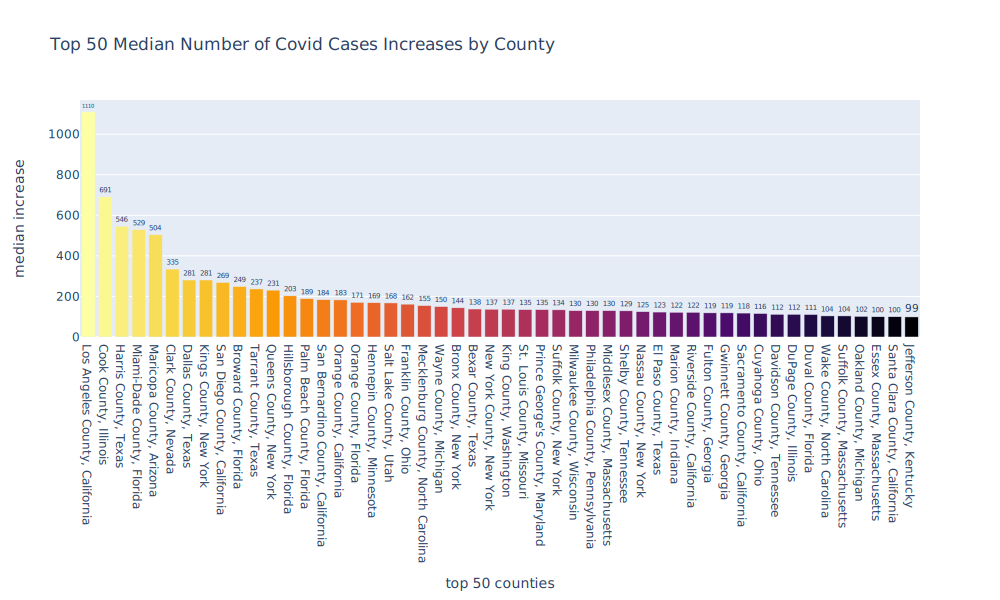

In [38]:
import plotly.graph_objs as go

by_class = highest_median

x = highest_median["COUNTY_AND_STATE"]
y = highest_median["median_increase"]
state_names = highest_median["STNAME"]
fig = go.FigureWidget(data=[go.Bar(x=x, 
                                   y=y,
                                   marker={'color': np.arange(len(x)),'colorscale': "inferno_r"}, 
                                   text = y
                                   )]) 


fig.update_traces(textposition='outside', textfont_size=14)

fig.update_layout(height=600, width=1000)

fig.layout.title = "Top 50 Median Number of Covid Cases Increases by County"

#label x and y axis
fig.update_layout(xaxis_title = 'top 50 counties')
fig.update_layout(yaxis_title = 'median increase')


fig.show("svg")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2b

Create a visualization that shows the overall county-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all questions that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

In [39]:
cases.head(3)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,median_increase
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8959,9012,9048,9063,9108,9145,9207,9246,9287,10.0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33968,34063,34142,34246,34393,34536,34726,34872,34950,24.0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3166,3184,3197,3207,3225,3243,3260,3282,3295,3.0


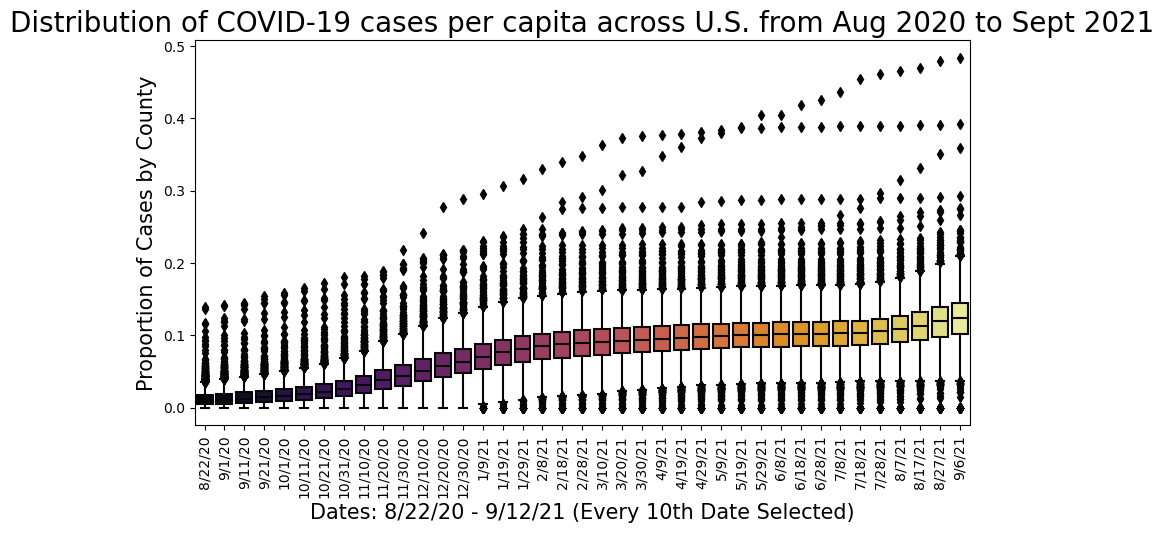

In [40]:
# using box plots with seaborn and matplot  
DF = pd.DataFrame()
for column in county_data.loc[:,'8/22/20':'9/12/21':10].columns:
    m = (county_data[column] / county_data["POPESTIMATE2020"])
    DF[column] = m
    
plt.figure(figsize=(10,5))
sns.boxplot( data=DF, palette="inferno")
plt.xlabel("Dates: 8/22/20 - 9/12/21 (Every 10th Date Selected)",size=15)
plt.ylabel("Proportion of Cases by County", size=15)
plt.title("Distribution of COVID-19 cases per capita across U.S. from Aug 2020 to Sept 2021", size=20)
plt.xticks(rotation=90);


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2c

Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

<!--
BEGIN QUESTION
name: q2c
points: 3
manual: True
-->

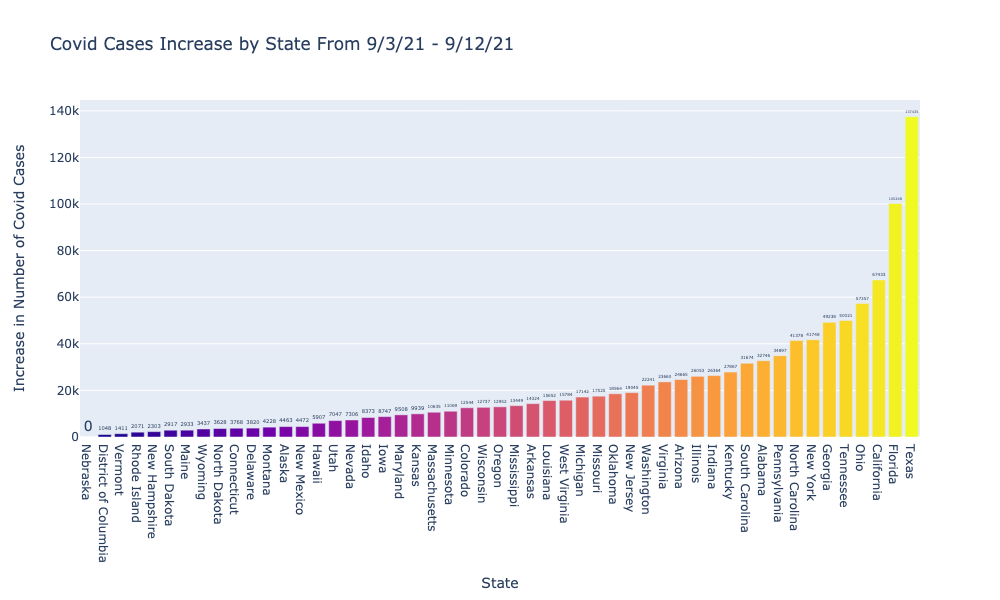

In [41]:
states_left = county_data[["9/3/21", "STNAME"]].groupby("STNAME").sum()
states_right = county_data[["9/12/21", "STNAME"]].groupby("STNAME").sum()

differences = states_right["9/12/21"] - states_left["9/3/21"]

states_cases = states_left.join(states_right)
states_cases["State Increase"] = differences
states_cases = states_cases.sort_values("State Increase")
states_cases.head()


# by_class = highest_median

state_x = states_cases.index
state_y = states_cases["State Increase"]
# state_names = highest_median["STNAME"]
fig = go.FigureWidget(data=[go.Bar(x=state_x, 
                                   y=state_y,
                                   marker={'color': np.arange(len(state_x)),'colorscale': "plasma"}, 
                                   text = state_y
                                   
                                   )]) 


fig.update_traces(textposition='outside', textfont_size=14)

fig.update_layout(height=600, width=1000, yaxis_title = "Increase in Number of Covid Cases", xaxis_title = " State")

fig.layout.title = "Covid Cases Increase by State From 9/3/21 - 9/12/21"
fig.show('png')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2d

Create a plot using a technique of your choice that visualizes the relationship between:

a) the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

b) the frequency of never, rarely or sometimes wearing a mask in the respective counties

*Hint*: You may find a description of the data [here](https://github.com/CSSEGISandData/COVID-19/blob/846fa9458cc2a8904d2492d14d3e6b4f399ec027/csse_covid_19_data/csse_covid_19_time_series/README.md).

<!--
BEGIN QUESTION
name: q2d
points: 3
manual: True
-->

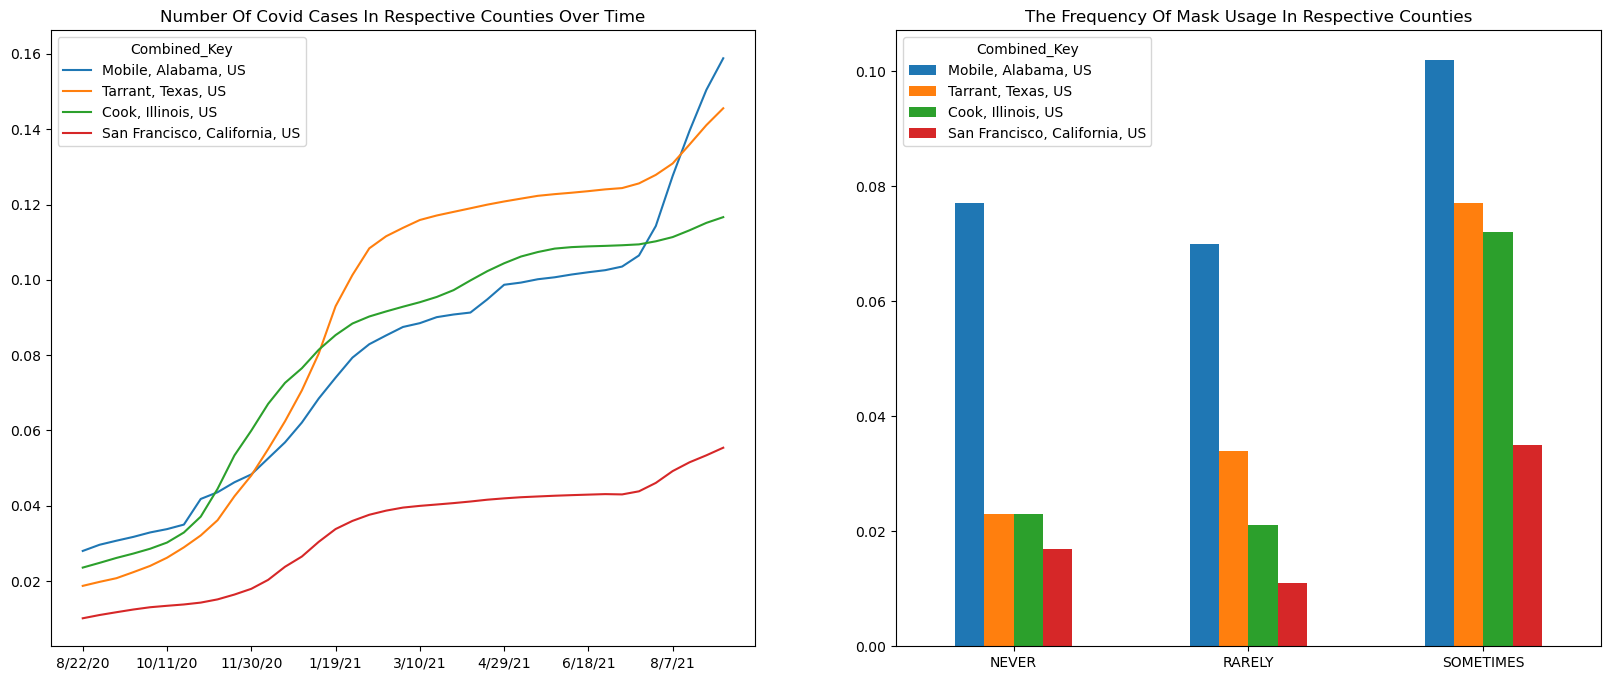

In [42]:
four_counties = (county_data
                 .set_index("Combined_Key")
                 .loc[['Mobile, Alabama, US','Tarrant, Texas, US','Cook, Illinois, US','San Francisco, California, US'],:]
                 .loc[:,'8/22/20':'9/12/21':10]
                )

frequency_count = (county_data
                   .set_index("Combined_Key")
                   .loc[['Mobile, Alabama, US','Tarrant, Texas, US','Cook, Illinois, US','San Francisco, California, US'],['NEVER','RARELY','SOMETIMES']]
                  )


county_total_pop = (county_data
                    .groupby("Combined_Key")
                    .sum()
                    .loc[['Mobile, Alabama, US','Tarrant, Texas, US','Cook, Illinois, US','San Francisco, California, US'],['POPESTIMATE2020']]
                    .values
                   )

four_counties_percapita = four_counties / county_total_pop


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))  # 1 row, 2 columns

# plt.title("Number Of Covid Cases In Respective Counties Over Time")
four_counties_percapita.T.plot(ax=ax1, title="Number Of Covid Cases In Respective Counties Over Time")


# plt.title("The Frequency Of Mask Usage In Respective Counties")
frequency_count.T.plot.bar(ax=ax2, title="The Frequency Of Mask Usage In Respective Counties");
plt.xticks(rotation=0)

plt.show();


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e

Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent **COVID-19 cases per capita on September 12, 2021**

b) the **frequency of never, rarely or sometimes wearing a mask**

*Hint*: Use `plotly` to generate a heatmap on a geographical plot of the United States!

<!--
BEGIN QUESTION
name: q2e
points: 5
manual: True
-->

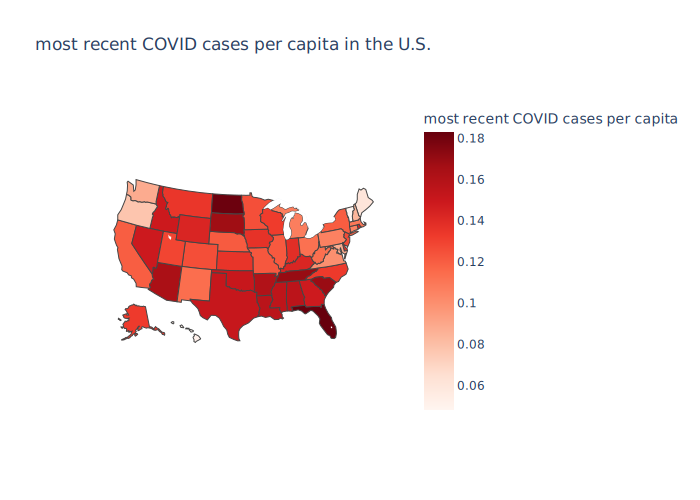

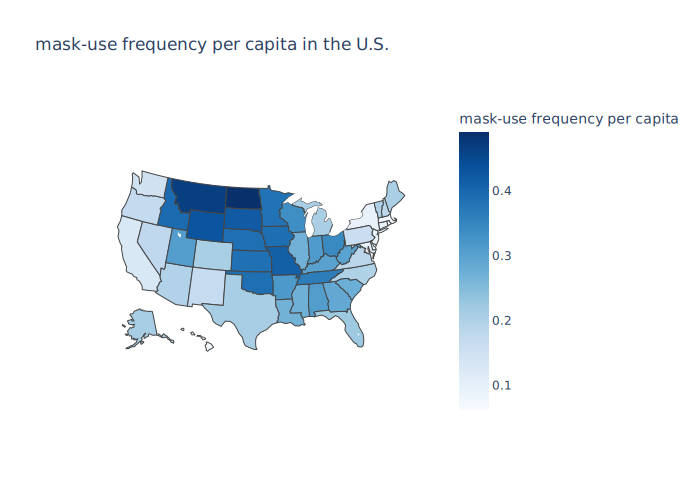

In [43]:
import plotly.graph_objects as go

# heatmap: x: locations (by states or by county), y: cases per capita, color: frequency

states_total_pop = county_data.groupby('STNAME').sum().loc[:,'POPESTIMATE2010']

most_recent_by_cases = county_data.groupby('STNAME').sum().loc[:,'9/12/21'] / states_total_pop
most_recent_by_cases #series

state_names = county_data['STNAME'].unique()
state_names # array

frequency_by_state_series = county_data.groupby(['STNAME','CTYNAME']).sum().loc[:,['NEVER','RARELY','SOMETIMES']].sum(axis = 1)
frequency_by_state = frequency_by_state_series.to_frame().groupby('STNAME').mean().values.flatten()
frequency_by_state

d = {'most recent cases':most_recent_by_cases, 'frequency': frequency_by_state}

df_2e = pd.DataFrame(d).reset_index()
df_2e  


# https://plotly.com/python/choropleth-maps/
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
merged_2e = df_2e.merge(df, how = 'left', left_on= 'STNAME', right_on = 'state')

# most recent cases
fig_cases = go.Figure(data=go.Choropleth(
    locations=merged_2e['code'], # Spatial coordinates
    z = merged_2e['most recent cases'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "most recent COVID cases per capita",
))

fig_cases.update_layout(
    title_text = 'most recent COVID cases per capita in the U.S.',
    geo_scope='usa', # limite map scope to USA
)

fig_cases.show('svg')



# mask use frequency
fig_mask = go.Figure(data=go.Choropleth(
    locations=merged_2e['code'], # Spatial coordinates
    z = merged_2e['frequency'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "mask-use frequency per capita",
))

fig_mask.update_layout(
    title_text = 'mask-use frequency per capita in the U.S.',
    geo_scope='usa', # limite map scope to USA
)


fig_mask.show('svg')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2f

Describe and interpret the relationships in the plots above. What conclusions can be drawn about the COVID-19 dataset from these plots?

<!--
BEGIN QUESTION
name: q2f
points: 3
manual: True
-->

From the above first heatmap we can see that the states with the most COVID cases per capita are mostly concentrated in upper midwest (North Dakota) and south (especially around Florida, Tennessee, South Carolina, etc); from the second heatmap showing the mask use frequency, the states that don't like to use masks frequently (the darker region) also happens to concentrate on the upper midwest region and with North Dakota being the least likely to use a mask. 

From those two heatmaps we can draw a conclusion that the mask-usage frequency and the chances of getting COVID is inversely correlated: if you never/rarely use masks, you are more likely to get COVID.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Guided Unsupervised Exploration with SVD and PCA


<!-- BEGIN QUESTION -->

### Question 3a

Using **SVD**, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

*Hint*: The matrix $X$ should have rows that describe location.

<!--
BEGIN QUESTION
name: q3a
points: 3
manual: True
-->

In [44]:
pop_by_state = county_data.groupby('STNAME').sum().loc[:, ['POPESTIMATE2020','9/12/21']].reset_index() # dataframe, 51

#NOTE: vaccinations df columns are total count --> increased by date!!!
# use .mean()??? to get the average by states across the dates?
vax_stats = vaccinations.groupby('Province_State').sum().loc[:, ['People_Fully_Vaccinated','People_Partially_Vaccinated']] # dataframe,shape 61,2

# NOTE: most recent date is 9/26/21
vax_stats_recent = vaccinations.groupby('Province_State').last().loc[:, ['People_Fully_Vaccinated','People_Partially_Vaccinated']]

vax_stats_by_state = pop_by_state.merge(vax_stats_recent, how = 'left', left_on = 'STNAME', right_on = 'Province_State') # shape 51,4

# change vaccination rate to proportions
vax_stats_by_state['People_Fully_Vaccinated'] = vax_stats_by_state['People_Fully_Vaccinated'].values / vax_stats_by_state['POPESTIMATE2020'].values
vax_stats_by_state['People_Partially_Vaccinated'] = vax_stats_by_state['People_Partially_Vaccinated'].values / vax_stats_by_state['POPESTIMATE2020'].values

# standardize proportions???

# cases per capita
vax_stats_by_state['9/12/21'] = vax_stats_by_state['9/12/21'].values / vax_stats_by_state['POPESTIMATE2020'].values


avg_maskuse_by_state = county_data.groupby('STNAME').mean().loc[:,['NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].reset_index()

matrix_x = vax_stats_by_state.merge(avg_maskuse_by_state, how = 'inner', on = 'STNAME').drop(columns = ['POPESTIMATE2020'])


X = matrix_x.set_index('STNAME') # set state as index so X only contains numbers!!

#standardize data
X_mean = X.mean(axis = 0)
X_std = np.std(X, axis = 0)
X_stand = (X - X_mean)/ X_std

# use standardized X matrix
u, s, vt = np.linalg.svd(X_stand, full_matrices = False)

u, s, vt

(array([[-9.81877371e-02, -2.26509150e-01,  2.03525935e-03,
          7.38137329e-02,  1.14464112e-01,  1.55607414e-01,
         -2.89096041e-02,  7.46873964e-02],
        [-7.64204288e-02,  7.58530707e-02, -8.08512553e-03,
          6.47506013e-01, -9.68382106e-02, -2.83074207e-01,
         -1.92707852e-02,  9.30127196e-02],
        [ 4.82039568e-02, -1.43447788e-01, -1.74445254e-01,
         -1.17602738e-01,  1.38651830e-01,  1.44968512e-02,
         -7.61849069e-02,  6.70676365e-02],
        [-1.00749046e-01, -2.08765263e-01,  1.28548992e-02,
          6.52046722e-02, -1.24956640e-02,  5.26540371e-02,
         -2.12361482e-02, -2.54729217e-02],
        [ 1.55973986e-01, -1.68048145e-01,  9.15612118e-02,
          2.32263064e-02, -4.15604037e-02, -7.75771107e-02,
         -3.00907864e-02,  4.90630763e-02],
        [ 1.15912071e-02,  1.51096697e-01, -2.74296923e-02,
          2.36996611e-01, -6.29774988e-02, -1.77824948e-02,
         -2.56366311e-01, -1.15108981e-01],
        [ 2.0418

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

<!--
BEGIN QUESTION
name: q3b
points: 3
manual: True
-->

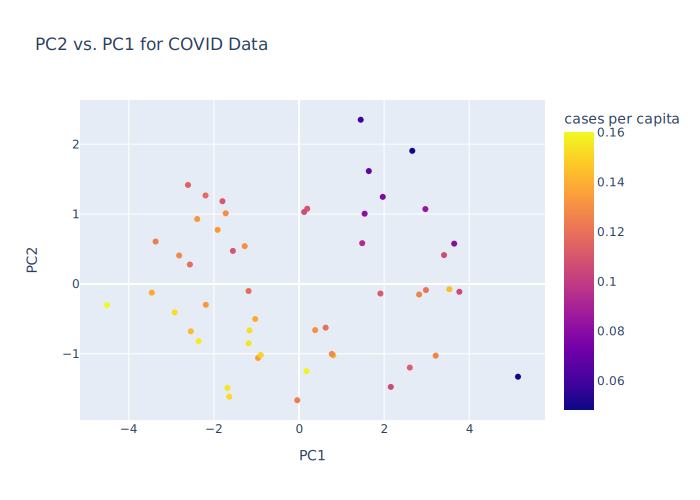

In [45]:
# lab 11, the same as above
X_2d = X_stand @ vt[0:2][:].T

state_names = X_2d.index

# visualize using the original number of cases per capita
import plotly.express as px

# color --> number of cases per capita (in each state)
# x-axis: PC1, y-axis: PC2

X_2d['cases per capita'] = X['9/12/21']
 
X_2d_states_col = X_2d.reset_index().rename(columns = {0:'PC1', 1:'PC2'})

plot = px.scatter(X_2d_states_col, x = 'PC1', y = 'PC2', color = 'cases per capita', hover_name = 'STNAME',
                 title = 'PC2 vs. PC1 for COVID Data')
plot.show('svg')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3c

What could the first and second principal component roughly represent? Interpret the visualization above and report any findings from the first two principal components given by PCA.

<!--
BEGIN QUESTION
name: q3c
points: 3
manual: True
-->

The first principal component roughly represents the number of cases per capita. The further a state is plotted to the right of the graph, the lower the cases per capita, but the further a state are to the left of the graph, the higher the cases per capita. The second principal component roughly indicates whether or not the mask usage is commonly never, rarely, sometimes, frequently, or always. The further a state is plotted towards the top of a graph, the higher the mask usage, but the lower a state is plotted towards the bottom of the graph, the lower the mask usage.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3d

Construct a scree plot displaying the proportion of variance captured by each principal component.

<!--
BEGIN QUESTION
name: q3d
points: 3
manual: True
-->

Text(0.5, 1.0, 'Fraction of Variance Explained by each Principal Component')

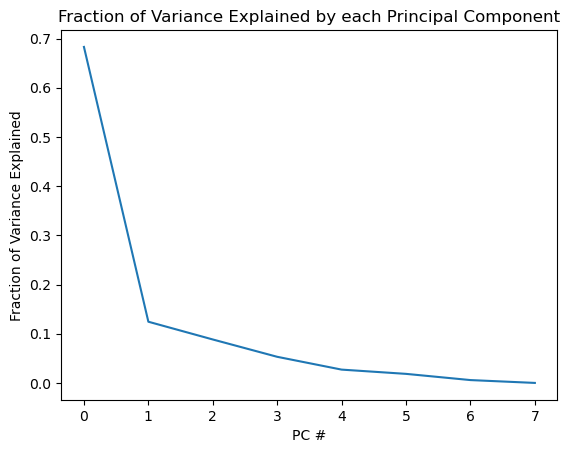

In [46]:
plt.plot(np.arange(len(s)), s**2 / sum(s**2));
plt.xticks(np.arange(len(s)),np.arange(len(s)));
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained');
plt.title('Fraction of Variance Explained by each Principal Component')

<!-- END QUESTION -->

### Question 3e

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

<!--
BEGIN QUESTION
name: q3e
points: 3
-->

In [47]:
X_2d_3e = X_2d_states_col.set_index('STNAME')
all_5_closest = [] # this should be a 2d array that stores 5 closests for each state (shape = 51, 5)
for state in X_2d_3e.index:
    pc1 = X_2d_3e.loc[state, 'PC1']
    pc2 = X_2d_3e.loc[state, 'PC2']
    exclude_1_state = X_2d_3e.drop(state)
    
    distance_for_state = {}
    for state_index in exclude_1_state.index:
        
        dist = ((pc1 - exclude_1_state.loc[state_index, 'PC1'])**2 + (pc2 - exclude_1_state.loc[state_index, 'PC2'])**2)**(1/2)
        distance_for_state[state_index] = dist
        
        #sort the dictionary by values
        sorted_dist_vals = sorted(distance_for_state.values())
        # get matching keys
        sorted_dist_keys = sorted(distance_for_state, key=distance_for_state.get)
        # get sorted distance dictionary, key = state names, val = distances
        distance_sorted = sorted(distance_for_state.items(), key=lambda x:x[1])
        
        # get closest 5
        closest_5 = distance_sorted[:5]
        
        # get closest 5 state names
        closest_5_states = [x[0] for x in closest_5]
    # outside of 2nd for loop, add each state's 5 neighbors    
    all_5_closest.append(closest_5_states)


state_mins = pd.DataFrame(all_5_closest, columns=['1st closest', '2nd closest','3rd closest','4th closest','5th closest']).set_index(X_2d_3e.index)

state_mins.head(10)

,1st closest,2nd closest,3rd closest,4th closest,5th closest
STNAME,,,,,
Alabama,Arkansas,Georgia,Mississippi,South Carolina,Louisiana
Alaska,Utah,Wisconsin,West Virginia,Indiana,Ohio
Arizona,Nevada,North Carolina,Texas,Florida,Illinois
Arkansas,Alabama,Mississippi,Georgia,South Carolina,Tennessee
California,Pennsylvania,Delaware,New Jersey,New York,New Mexico
Colorado,Michigan,New Hampshire,Virginia,Oregon,Alaska
Connecticut,District of Columbia,Rhode Island,Massachusetts,New York,Maryland
Delaware,California,New Jersey,New York,Rhode Island,Massachusetts
District of Columbia,Connecticut,Rhode Island,Massachusetts,Maryland,New York


<!-- BEGIN QUESTION -->

### Question 3f

Investigate the principal component neighbors for two states of your choice, and remark on any observations you have about their COVID-19 statistics given in the dataset, geographical or political ties. 

Compare these neighbors with the rankings from the visualization from Question 2c that depicted recent greatest increases in cases across states.

<!--
BEGIN QUESTION
name: q3f
points: 3
manual: True
-->

Looking at in particular Oregon, Washington, and Maine, we can see that looking geographically at Oregon and Washington are next to one another. This can lead us to believe that since they are close to one another, they must have similar bliefs/laws as to how they are taking precautions with covid. Furthermore, we are assured that Oregon and Washington do have similar standings do to their PCA closest neighbor where Oregon is Washington's 2nd nearest neighbor and Washington is Oregon's 1st nearest neighbor. In contrast, looking at the graph in 2c, Washington has about 10,000 more cases than Oregon. Another discovery was when looking at the PCA graph, since Washington and Oregon (Democratic States) are further towards the top of the graph, people in these states are further likely to wear maskes but looking lower down at Florida or Arkansas (republican states), theses states are less likely to wear masks

<!-- END QUESTION -->

### Question 3g

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

*Hint*: `geopy` has a function that can calculate distance between two pairs of latitude and longitude!

*Hint*: You should be plotting 1,275 points.

<!--
BEGIN QUESTION
name: q3g
points: 3
-->

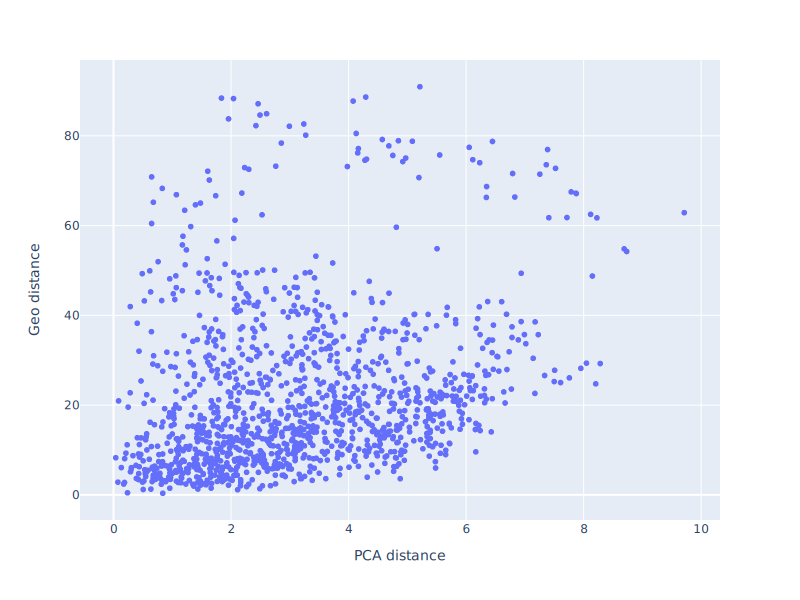

In [48]:
# 1275 --> total number of unique pairs of states n(n-1)/2

# create a new dataframe that contains 
#1) col of state pairs (a tuple?), 
#2) distance of PCA, 
#3) geographical distance
# x: PCA distance, y: geo distance
# the new dataframe has a shape of (1275, 3)

from itertools import combinations

# a clean PCA df, index = STNAME, col labels = 0,1
pca_df = X_2d.drop(columns = ['cases per capita']) # columns labeled 0,1

#NOTE: state_names is defined in previous questions

unique_pairs_states = [",".join(map(str, comb)) for comb in combinations(state_names, 2)] # each elem in the list is a str (of two states)
unique_pairs_states

state_pairs = []
for pair in unique_pairs_states:
    state_pairs.append(pair.split(','))
state_pairs

# use pca_df, calculate pca distance
pca_distance = []
for pair in state_pairs: # note: a pair looks like: ['Alabama', 'Alaska']
    pc1_0 = pca_df.loc[pair[0]][0]
    pc2_0 = pca_df.loc[pair[0]][1]
    
    pc1_1 = pca_df.loc[pair[1]][0]
    pc2_1 = pca_df.loc[pair[1]][1]
    
    dist = np.sqrt((pc1_1 - pc1_0 )**2 + (pc2_1 - pc2_0)**2 )
    pca_distance.append(dist)
    

# calculate geo distance
# dataframe with lat and long, index = STNAME
lat_long_df = county_data.groupby('STNAME').mean().loc[:,['Lat','Long_']]

geo_distance = []
for pair in state_pairs: # note: a pair looks like: ['Alabama', 'Alaska']
    lat_0 = lat_long_df.loc[pair[0]][0]
    long_0 = lat_long_df.loc[pair[0]][1]
    
    lat_1 = lat_long_df.loc[pair[1]][0]
    long_1 = lat_long_df.loc[pair[1]][1]
    
    dist = np.sqrt((lat_0 - lat_1 )**2 + (long_0 - long_1)**2 )
    geo_distance.append(dist)
    

three_g = {'state pairs':state_pairs, 'PCA distance':pca_distance, 'Geo distance':geo_distance}
df_3g = pd.DataFrame(data = three_g)
df_3g


# plotting, scatter plot
x, y = df_3g['PCA distance'], df_3g['Geo distance']


fig = px.scatter(df_3g, x= x , y= y, hover_name = 'state pairs')
fig.update_layout(width = 800, height = 600)

fig.show('svg')

### Question 3h

Interpret the relationship displayed in part (g). What does this suggest about the role that geography plays within this dataset despite no geographical information explicitly encoded within the matrix  $X$ from part (a)?

<!--
BEGIN QUESTION
name: q3h
points: 3
-->

As the PCA distance for a state pair increases, the geographical distance between the state pair also roughly increases. The PCA distance and the geographical distance have a roughly postive relationship, so this suggests that we can probably get a rough idea of how two states are geographically related just by examing the distance of first two PCs, and since the correlation between the PCA distance and the geographical distance is not very strong, we can also infer that the geographical distance/location does not contribute much to the total variance showed in the data.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

<br/><br/><br/>

## Looking at State's Voting Preference using Open EDA

Perform EDA of your choice on the data to generate 2 visualizations. You may follow the line of investigation in the guided sections by visualizing the relationship between safety protocols and the spread of COVID-19 spatially or temporally, or you may explore other areas of your choice. 

For each visualization, make sure to address the following:

1. Address a relationship in the data concerning the spread, effect, or prevention of COVID-19 through a visualization, with at *most* one univariate data visualization. If needed, use an unsupervised learning technique such as PCA to reveal patterns within the data.
2. Comment on the visualization in terms of the distribution, trends, and patterns it shows.
3. Comment on what the visualization indicates about the data with regards to the features you may choose for a supervised learning task.

<!--
BEGIN QUESTION
name: q4
points: 30
manual: True
-->

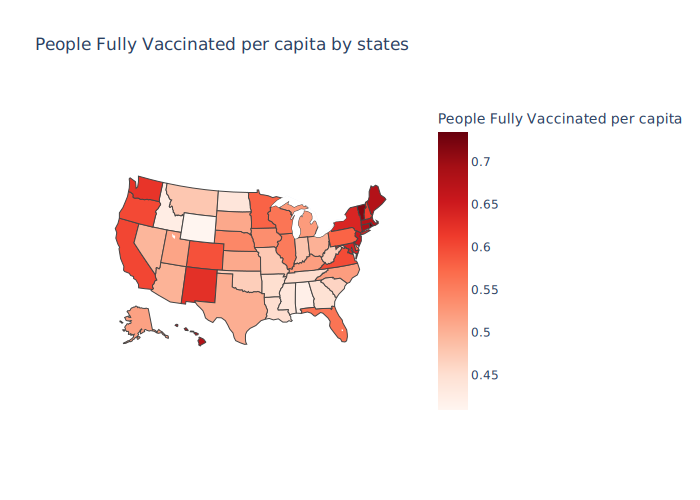

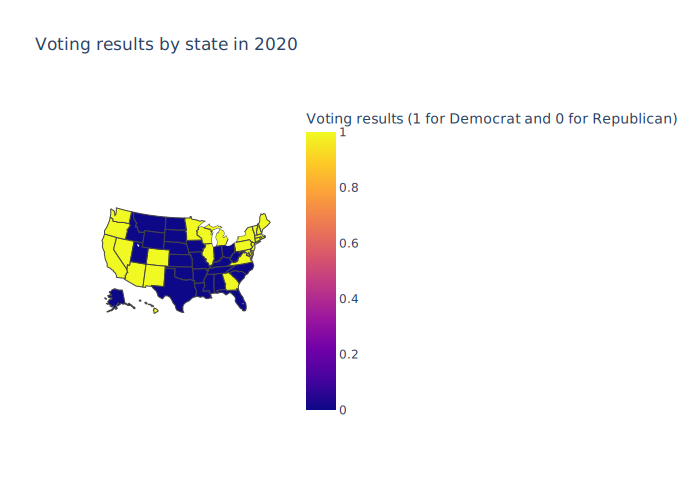

In [49]:
# new research question: plot heatmap of vax rate and political voting for U.S., seek for correlation

# vax dataframe, col = Province_State, People_Fully_Vaccinated (by the most recent date, 9/26/21)
vax_fully_by_state = vaccinations.groupby('Province_State').max().reset_index()[['Province_State','People_Fully_Vaccinated']]
vax_fully_by_state # shape, 61 rows


# clean vax_fully_by_state to make it per capita
# population df has STNAME, POPESTIMATE2020

#merge population and vax_fully...
vax_fully_by_state = population.merge(vax_fully_by_state, how = 'left', left_on = 'STNAME', right_on = 'Province_State')
# convert fully vaxed to per capita
vax_fully_by_state['People_Fully_Vaccinated per capita'] = vax_fully_by_state['People_Fully_Vaccinated'] / vax_fully_by_state['POPESTIMATE2020']

vax_fully_by_state = vax_fully_by_state.drop(columns = ['Province_State', 'POPESTIMATE2020','People_Fully_Vaccinated'])

vax_fully_by_state # cleaned df, cols = STNAME, People_Fully_Vaccinated per capita

# merge with introduced df
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
merge_q4_vax = vax_fully_by_state.merge(df, how = 'left', left_on = 'STNAME', right_on = 'state')
merge_q4_vax

# fully vax rate by state
fig_vax = go.Figure(data=go.Choropleth(
    locations=merge_q4_vax['code'], # Spatial coordinates
    z = merge_q4_vax['People_Fully_Vaccinated per capita'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "People Fully Vaccinated per capita",
))

fig_vax.update_layout(
    title_text = 'People Fully Vaccinated per capita by states',
    geo_scope='usa', # limite map scope to USA
)

fig_vax.show('svg')



import pandas as pd
votes_2020 = pd.read_csv("data/Popular vote backend - Sheet1.csv")
votes_2020 = votes_2020.iloc[4:,0:2]  # sliced

#one-hot encoding, cols = state, called_D (1 for D, 0 for R)
votes_2020_encoded = pd.get_dummies(votes_2020, columns = ['called']).drop(columns = 'called_R')
votes_2020_encoded


# merge the new df with the df we have
merge_q4_vote = merge_q4_vax.merge(votes_2020_encoded, how = 'left', left_on = 'STNAME', right_on ='state')
merge_q4_vote

# voting result 2020 by state
fig_vote = go.Figure(data=go.Choropleth(
    locations=merge_q4_vote['code'], # Spatial coordinates
    z = merge_q4_vote['called_D'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    # colorscale = 'blues',
    autocolorscale = True,
    colorbar_title = "Voting results (1 for Democrat and 0 for Republican)",
))

fig_vote.update_layout(
    title_text = 'Voting results by state in 2020',
    geo_scope='usa', # limite map scope to USA
)


fig_vote.show('svg')

From the first visualization (People Fully Vaccinated per capita by states), we can see that people who are fully vaccinated are mostly concentrated on the westcoast (California, Oregon, Washingtong, etc) and upper eastcoast (Maine, Vermont, etc), and the central and southern part of U.S. is less likely to be fully vaccinated. 
From the second visualization (Voting results by state in 2020), we can see that the westcoast states (Califonia, Oregon, Washington, etc) and the eastcoast states (Maine, Vermont, New York, etc) voted for Democrats (shown as yellow in graph), and the rest (the central and south) voted for Republican(shown as blue in graph).

Based on those two graphs, the states with higher vaccination rates are mostly Democratic, and lower vaccination rates are mostly Republican, so we can infer that the vaccination rates and the political preference are correlated. We will use vaccination rates as a feature to predict the politcal preferences in the supervised learning task.